In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
import ase.io as aio
import scipy.io as sio
import glob
from toolz.curried import pipe, curry

In [3]:
from ase.neighborlist import neighbor_list

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.color'] = 'r'
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [5]:
from ase import Atoms
import numpy.fft as mf

In [11]:
import numpy.fft as mf

def epanechnikov(u, h):
    p = 0.75*(5**(-0.5))*(1 - (u**2)/(5*h**2))/h
    p[p<0] = 0
    return p


def mk_kernel(width, x):
    steps = x[1:] - x[:-1]
    width = width/np.sqrt(5)

    if not np.all(np.isclose(steps[0], steps)):
        raise ValueError('Bins need to be same width!')
        return None

    k_half = int((np.sqrt(5)*width)//steps[0] + 1)
    u = np.linspace(-k_half*steps[0],k_half*steps[0],k_half*2+1)

    kernel = epanechnikov(u=u, h=width)
    shift_to_mid = -len(kernel)//2 + 1
    kernel_arr = np.zeros(len(x))
    kernel_arr[:len(kernel)] = kernel
    kernel_arr = np.roll(kernel_arr, shift_to_mid)
    return kernel_arr


def conv_kernel(kern_arr, p):
    h1 = mf.fftn(kern_arr)
    h2 = mf.fftn(p)
    density = mf.ifftn(h1.conj() * h2).real
    return density

**Computation of RDF using neighbor_list taking into account periodicity**

In [6]:
atoms = aio.read("data/struct_1.cif")

**Computation of RDF for MFI using neighbor_list taking into account periodicity**

In [7]:
sym1 = "H"
sym2 = "C"

In [18]:
%%time
cif = "data/struct_1.cif"

atom = pipe(cif, 
            lambda cif: aio.read(cif), 
            lambda x: x.repeat([1, 1, 1]))

syms = np.asarray(atom.get_chemical_symbols())
idx_o = np.where(syms == sym1)[0]
idx_s = np.where(syms == sym2)[0]

coords = atom.get_positions()
coords_o = coords[idx_o]
coords_s = coords[idx_s]

cell = atom.get_cell()

N_o = len(idx_o)
N_s = len(idx_s)

pbc = atom.get_pbc()

atom_o = Atoms(positions=coords_o, 
               cell=cell, pbc=pbc, 
               symbols=[sym1]*N_o)

atom_s = Atoms(positions=coords_s, 
               cell=cell, pbc=pbc, 
               symbols=[sym2]*N_s)


cutoff_ = 5
bins = np.linspace(0.0, cutoff_ + 2, 1001)
vols = 4 / 3 * np.pi * (bins[1:]**3 - bins[:-1]**3)

a = atom_o
N = len(a)

i, j, d, D = neighbor_list('ijdD', a, cutoff=cutoff_, self_interaction=True)

h, bin_edges = np.histogram(d, bins)

pdf_C = h / N

d_bin = (bin_edges[1] - bin_edges[2]) / 2
bin_centers = bin_edges[:-1] + d_bin

a = atom_s
N = len(a)

i, j, d, D = neighbor_list('ijdD', a, cutoff=cutoff_, self_interaction=True)

h, bin_edges = np.histogram(d, bins)

pdf_H = h / (N)

CPU times: user 232 ms, sys: 273 ms, total: 505 ms
Wall time: 95.9 ms


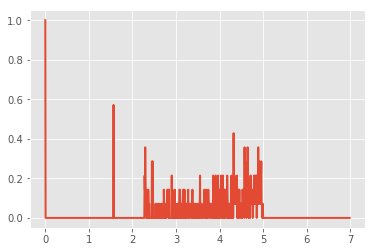

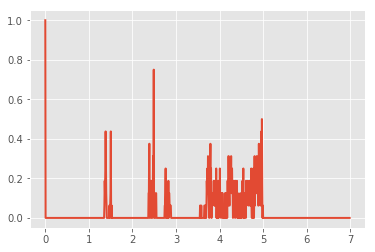

In [19]:
d_bin = (bin_edges[1] - bin_edges[2]) / 2
bin_centers = bin_edges[:-1] + d_bin

plt.plot(bin_centers, pdf_C)
plt.show()

plt.plot(bin_centers, pdf_H)
plt.show()

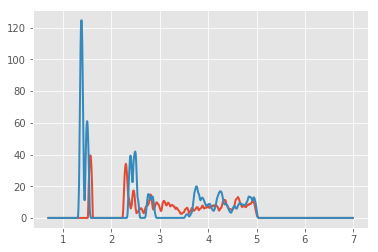

In [21]:
ix = 100
sing_kernel = mk_kernel(width=0.05, x=bin_centers[ix:])

smooth_pdf_C = conv_kernel(sing_kernel, pdf_C[ix:] / vols[ix:])
smooth_pdf_H = conv_kernel(sing_kernel, pdf_H[ix:] / vols[ix:])

plt.plot(bin_centers[100:], smooth_pdf_C)
plt.plot(bin_centers[100:], smooth_pdf_H)
plt.show()